## Wavelet processing with OIB 2-8 GHz SnowRadar data from CRESIS (MATFILE v7)

Example of using the wavelet process with CRESIS mat data.

Note this approach is still in testing and has not been validated against in situ data.

&copy; J.King 2018

In [1]:
#pyWavelet modules
from pyWavelet import snowradar, picklayers

#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [3]:
radar_file = "./data/sr/Data_20160420_02_090.mat"
radar_dat = snowradar.SnowRadar(radar_file, l_case='full')
radar_dat.surf_bin, radar_dat.surface = radar_dat.get_surface()

Processing: C:\Users\kingj\Documents\Projects\2018-2019\250618_Wavelet\pyWavelet\pyWavelet\data\sr\Data_20160420_02_090.mat


Convert the radar's GPS time to UTC and account for leap seconds

In [4]:
example_date = datetime.datetime.utcfromtimestamp(radar_dat.time_utc[0])
print(example_date)

2016-04-20 16:25:50.087683


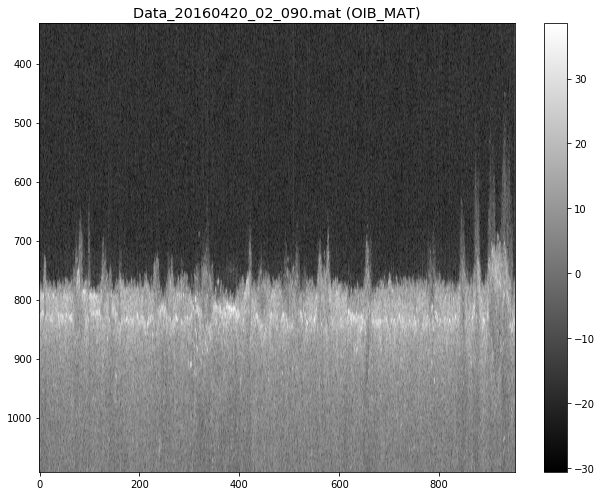

In [5]:
data_bounds = radar_dat.get_bounds(5,2)
radar_dat.plot_quicklook(ylim = list(data_bounds))

In [6]:
radar_sub = radar_dat.data_radar[data_bounds[1]:data_bounds[0],:]

### Signals stuff

In [7]:
oversample_num = 1000
num_nyquist_ts = 100
nyquist_sf = 2*radar_dat.bandwidth
fs = nyquist_sf *oversample_num 
time_step = 1/fs 
max_time  = num_nyquist_ts*oversample_num*time_step
time_vect = np.arange(-max_time,max_time,time_step)

In [8]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.07570516616161616
0.20186025505333335


### This applies the picklayer function to every trace
TODO: Multi thread and bake into snowradar class

In [9]:
l_as, l_si = np.apply_along_axis(
    picklayers.picklayers, 
    0, 
    radar_sub,
    radar_dat.n2n,
    radar_dat.dfr,
    n_snow
)

In [10]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow

# Retrieval output

Max along-track resolution
Mean depth (m): 0.6035640117389908
StDev of  depth (m): 0.3095409092204984

5-bin averaged along-track 
Mean snow depth (m): 0.6039150586756487
StDev of snow depth (m): 0.23024586554133852


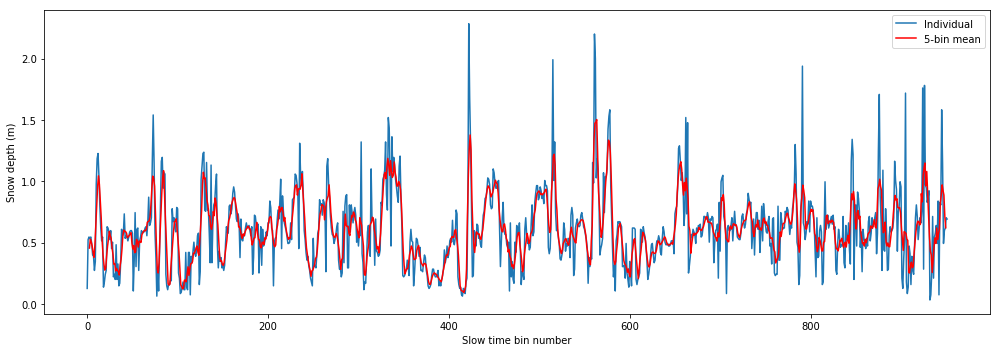

In [11]:
N = 5
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
#ax.plot(np.arange(0, len(snow_depth_rollin)),snow_depth_rollin, color='r')
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')

#ax.plot(l_as, color='b')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

#fig.savefig('20170310_01_088_Depth.pdf')

(array([ 10.,  14.,  26.,  44.,  50.,  52.,  82., 126., 108., 114.,  84.,
         46.,  27.,  32.,  46.,  30.,  22.,  11.,   8.,   4.,   5.,   1.,
          3.,   0.,   3.]),
 array([0.09223001, 0.148658  , 0.205086  , 0.26151399, 0.31794199,
        0.37436998, 0.43079797, 0.48722597, 0.54365396, 0.60008196,
        0.65650995, 0.71293795, 0.76936594, 0.82579394, 0.88222193,
        0.93864993, 0.99507792, 1.05150592, 1.10793391, 1.16436191,
        1.2207899 , 1.2772179 , 1.33364589, 1.39007389, 1.44650188,
        1.50292988]),
 <a list of 25 Patch objects>)

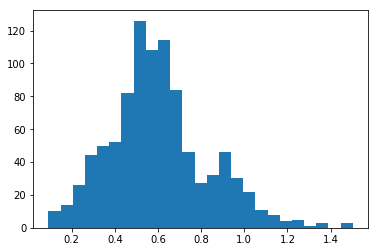

In [12]:
plt.hist(snow_depth_rollin, bins=25)

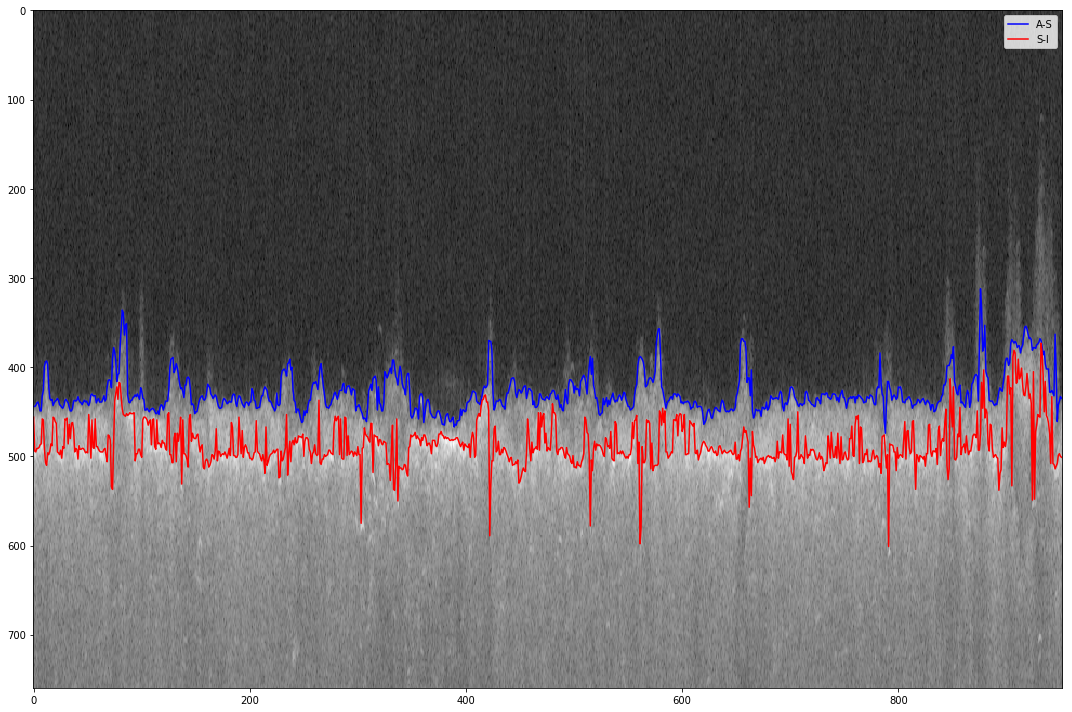

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(20 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
ax.legend(["A-S","S-I"],loc="upper right")
ax.set_aspect('auto')
fig.tight_layout();

810


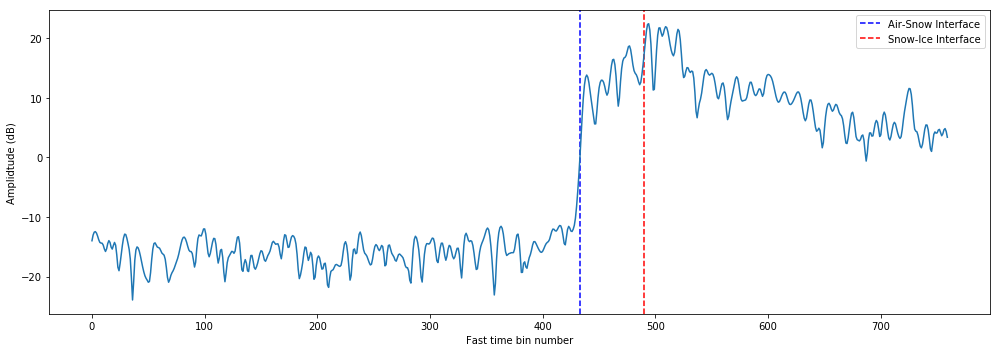

In [15]:
col_idx = np.random.randint(0, radar_sub.shape[1])
print(col_idx)
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
ax.plot(10*np.log10(radar_sub[:,col_idx]), label=None)
#ax.plot(radar_sub[:,col_idx], label=None)

# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
fig.tight_layout();